# Twitter Data Analysis.

Extracting Twitter data , Pre-processing and Mining for trending keywords.

With the current COVID-19 pandemic consequences we tried to understand how "recession" is trending over twitter.

In [40]:
import requests
import base64
import nltk
import requests
from nltk.corpus import twitter_samples
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import naive_bayes
import re 
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('twitter_samples')

Twitter API Connection.

In [41]:
def search_data_twitter(my_search_term):
    client_key = 'm0XpaTv7IKr8zvcWq2P1Z4J0R'
    client_secret = 'Q26S6vTujHvjFZXY9jctZgC7vBNcs6HK2VQN78B84rRw1NQ11K'

    key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
    b64_encoded_key = base64.b64encode(key_secret)
    b64_encoded_key = b64_encoded_key.decode('ascii')

    base_url = 'https://api.twitter.com/'
    auth_url = '{}oauth2/token'.format(base_url)

    auth_headers = {
        'Authorization': 'Basic {}'.format(b64_encoded_key),
        'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
    }

    auth_data = {
        'grant_type': 'client_credentials'
    }

    auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)
    print("Status :",auth_resp.status_code)

    access_token = auth_resp.json()['access_token']

    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)    
    }

    search_params = {
        'q': my_search_term,
        'result_type': 'recent',
        'count': 100,
        'tweet_mode':'extended',
        'retweeted':'False',
        'iso_language_code': 'en'
    }

    search_url = '{}1.1/search/tweets.json'.format(base_url)

    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
    
    return search_resp

    

In [42]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

Analyzing the trends in "recession" on Twitter.

In [43]:
data = search_data_twitter('recession')
tweet_data = data.json()

Status : 200


In [44]:
my_tweets = []
for x in tweet_data['statuses']:
    my_tweets.append(x['full_text'])

In [45]:
def clean_data(my_tweets):
    tweet_list = []
    for i in my_tweets:
        proc_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                        '(?:%[0-9a-fA-F][0-9a-fA-F]))+','',i)

        proc_tweet = re.sub("(@[A-Za-z0-9_]+)","", proc_tweet)
    
        proc_tweet = proc_tweet.lower()
   
        proc_tweet = re.sub(r'\W', ' ', proc_tweet)

        proc_tweet = re.sub(r'\s+', ' ', proc_tweet, flags=re.I)

        proc_tweet = proc_tweet.replace('rt','')

        proc_tweet = re.findall(r'\w+', proc_tweet) 
        
        tweet_list.append(proc_tweet)
    
    return tweet_list

In [46]:
my_tweets_freq_count = my_tweets.copy()

In [47]:
my_tweets_freq_count = clean_data(my_tweets_freq_count)

Analyzing Word Frequency.

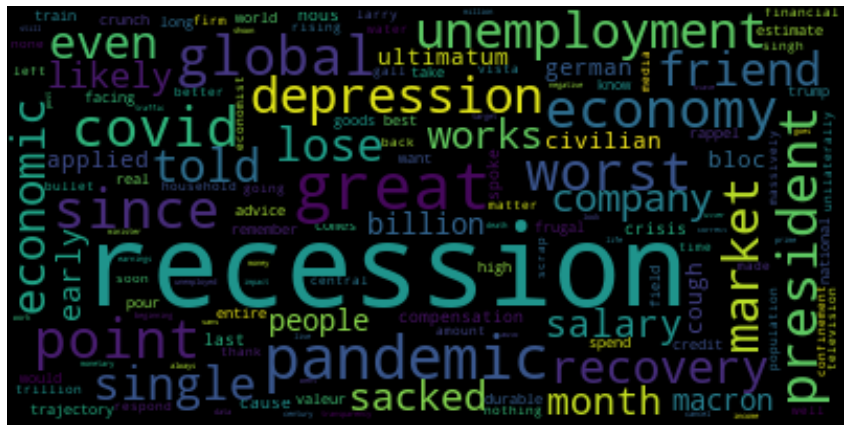

In [48]:

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import FreqDist
from wordcloud import WordCloud
from matplotlib import pyplot as plt

words = set(nltk.corpus.words.words())
my_clean_list=[]
for i in my_tweets_freq_count:
    for j in i:
        if (j not in stopwords.words('english') and (j in words) and len(j) > 3):
            my_clean_list.append(j)
        
#frequency count
freq_dist_pos = FreqDist(my_clean_list)

wcloud = WordCloud().generate_from_frequencies(freq_dist_pos)
plt.figure(figsize=(15,16))
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 499.5, 499.5, -0.5)
plt.show()

In [49]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [50]:
tweet_3 = pd.DataFrame(my_tweets,columns=['Tweets'])
tweet_3['Real_Tweets']=tweet_3['Tweets']

In [51]:
#removing the tweets username.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "@[\w]*")
#removing all the RT: text from the Tweets.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "RT :")

tweet_3['Tweets'] = tweet_3['Tweets'].str.replace('[^a-zA-Z#]',' ')

tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "\n")

tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "r'^https?:\/\/.*[\r\n]*'")

#removing the emoticons
tweet_3['Tweets'] = tweet_3['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tweet_3['Tweets_len'] = tweet_3['Tweets'].apply(len)

#removing tweets totally in different languages
drop_tweets = tweet_3[tweet_3['Tweets_len'] == 0].index

tweet_3.drop(index=drop_tweets,inplace=True)

#drop duplicates
tweet_3.drop_duplicates(subset=['Tweets'], keep = 'first',inplace= True)

In [52]:
tweet_3

,Tweets,Real_Tweets,Tweets_len
0,Covid Recession #VoteBlueNoMatterWho https eSo...,RT @TomthunkitsMind: Covid 19 and Recession.\n...,53
1,recession this global trajectory What will rec...,RT @AtifRMian: The 2008 recession did this to ...,78
2,Another important point from story Lotta seein...,RT @HotlineJosh: Another important point from ...,89
3,revive global economy Recession unlikely impos...,How to revive the global economy: Recession is...,64
4,early recession bring deal Sweden social democ...,@fahmi_fadzil @fazli_zakaria early 1930 recess...,76
5,recovery People discussing whether going reces...,RT @R2Rsquared: **** An ABC recovery\n\nPeople...,67
6,Comment Balancing risks health recession https...,RT @timescolonist: Comment: Balancing the risk...,56
7,billion Twilio gives best advice startups faci...,RT @businessinsider: The CEO of $15 billion Tw...,84
8,Want contribute column featured July issue #MJ...,RT @MJBizDaily: Want to contribute a column to...,93
9,Macron issues ultimatum Europe German bloc cou...,RT @Schuldensuehner: Macron issues ultimatum t...,105


NLP <br>
Preparing data for vectorization.<br>
Vectorization is a methology of converting the words into real numbers which is used to find the word similarities.

In [53]:
stopset = set(stopwords.words('english'))
desc = tweet_3['Tweets'].values
vectorizer = TfidfVectorizer(stop_words = stopset)
X = vectorizer.fit_transform(desc)

In [54]:
word_features = vectorizer.get_feature_names()

K means Clustering.

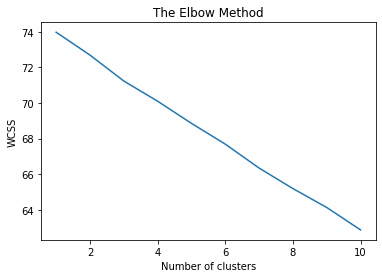

In [55]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='random',max_iter=500,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [60]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

Clustering of Data to understand the similarity in the keywords.

In [63]:
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))
    print("")

0 : recession, even, global, economy, spend, economic, impact, want, early, take, people, field, push, damn, state, thank, https, work, life, always, trajectory, estimate, comes, income, scenarios

1 : https, recession, covid, recovery, cession, risks, ylzm, cydy, credit, crisis, instagram, caused, esoqwdandc, votebluenomatterwho, last, great, heading, xtuflhaxv, towards, brace, needed, long, online, target, businesses

2 : billion, fundraising, startups, facing, frugal, advice, twilio, gives, crunch, best, stands, beat, uber, value, currently, founded, market, recession, great, twlo, investors, shdpzkl, customers, focus, ctts

3 : high, back, salary, works, friend, company, told, month, retrenching, sacked, nous, point, president, train, lockdown, economy, school, dropout, dudes, college, supposed, coming, person, control, totally

4 : pandemic, worst, unemployment, likely, century, since, minister, prime, great, younger, loss, vulnerable, sinz, workers, compensation, receiving, appli